# Import local .csv

In [1]:
import pandas as pd

df = pd.read_csv('cust_act1.csv')

class GetInfo():
    def __init__(self, df):
        self.df = df
        
    


    print(f"No. of unique values: {len(set(df["month"]))}")
    print(f"The unique values: {set(df['month'])}")
    print(f"Range of column: {max(df["informational"] - min(df["informational"]))}")
    display(df.head(10))
    df.info()

No. of unique values: 10
The unique values: {'Dec', 'May', 'Feb', 'Sep', 'Nov', 'Aug', 'Jul', 'June', 'Mar', 'Oct'}
Range of column: 12


,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values,month,operating_systems,browser,region,traffic_type,visitor_type,weekend,revenue
0,0.0,0.0,0,0.0,4.0,0.0,0.2000,0.200,0.0,May,Android,Google Chrome,North America,Twitter,Returning_Visitor,False,False
1,0.0,0.0,0,0.0,26.0,876.0,0.0000,0.026,0.0,Nov,Windows,Google Chrome,Western Europe,Google search,Returning_Visitor,True,False
2,2.0,99.4,0,0.0,19.0,368.0,0.0396,0.052,0.0,Sep,Windows,Google Chrome,Asia,Twitter,Returning_Visitor,False,False
3,0.0,0.0,0,0.0,20.0,1432.0,0.0248,0.028,1.8,Dec,Windows,Google Chrome,Western Europe,Instagram ads,Returning_Visitor,False,True
4,0.0,0.0,0,0.0,33.0,694.0,0.0141,0.032,0.0,May,Android,Google Chrome,North America,Instagram ads,Returning_Visitor,False,False
5,1.0,63.0,0,0.0,29.0,579.0,0.0194,0.023,0.0,Mar,MACOS,Safari,North America,Google search,Returning_Visitor,False,False
6,3.0,87.0,0,0.0,11.0,1400.0,0.0000,0.022,0.0,Mar,Android,Google Chrome,Western Europe,Google search,New_Visitor,True,False
7,0.0,0.0,0,0.0,NaN,1134.0,0.0033,0.018,0.0,Dec,MACOS,Safari,North America,Youtube channel,New_Visitor,False,False
8,0.0,0.0,0,0.0,3.0,17.0,0.0400,0.120,0.0,June,Windows,Microsoft Edge,North America,Instagram ads,Returning_Visitor,False,False
9,4.0,15.8,0,0.0,11.0,340.0,0.0000,0.016,0.0,Aug,Windows,Microsoft Edge,South America,Instagram Page,New_Visitor,False,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   administrative            11760 non-null  float64
 1   administrative_duration   11418 non-null  float64
 2   informational             12330 non-null  int64  
 3   informational_duration    11994 non-null  float64
 4   product_related           11751 non-null  float64
 5   product_related_duration  12129 non-null  float64
 6   bounce_rates              12330 non-null  float64
 7   exit_rates                12330 non-null  float64
 8   page_values               12330 non-null  float64
 9   month                     12330 non-null  object 
 10  operating_systems         12319 non-null  object 
 11  browser                   12330 non-null  object 
 12  region                    12330 non-null  object 
 13  traffic_type              12330 non-null  object 
 14  visito

# Perform column dtype transform

In [2]:
from db_utils import DataTransform
from db_utils import DataFrameInfo as dfinfo

dtype_change = {
    "visitor_type": "category",
    "traffic_type": "category",
    "region": "category",
    "browser": "category",
    "operating_systems": "category",
    # "months": "category"
}

# Perform the transform from dict
DataTransform(df).changetype(dtype_change)
# Special case for months to be an ordered category
months_ordered = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
df['month'] = pd.Categorical(df['month'], categories=months_ordered, ordered=True)


Successfully changed 'visitor_type' to category
Successfully changed 'traffic_type' to category
Successfully changed 'region' to category
Successfully changed 'browser' to category
Successfully changed 'operating_systems' to category


# Display No. and % of Null values

In [7]:
# print(f"\tNo. null:\n\n{df.isna().sum()}\n\n\tPercent Null:\n\n{(df.isna().sum())/len(df)*100}")

dfinfo(df).null()

,ColumnName,CountNull,PercentageNull
0,administrative,570,4.62
1,administrative_duration,912,7.40
2,informational,0,0.00
3,informational_duration,336,2.73
4,product_related,579,4.70
5,product_related_duration,201,1.63
6,bounce_rates,0,0.00
7,exit_rates,0,0.00
8,page_values,0,0.00
9,month,0,0.00


# Visualise Correlation Heatmap

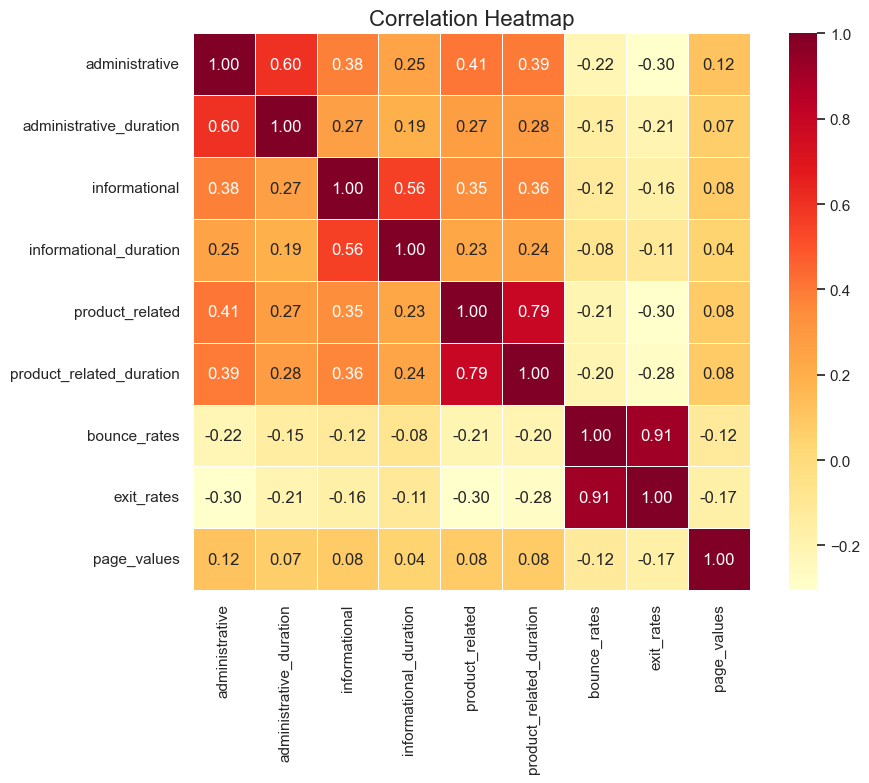

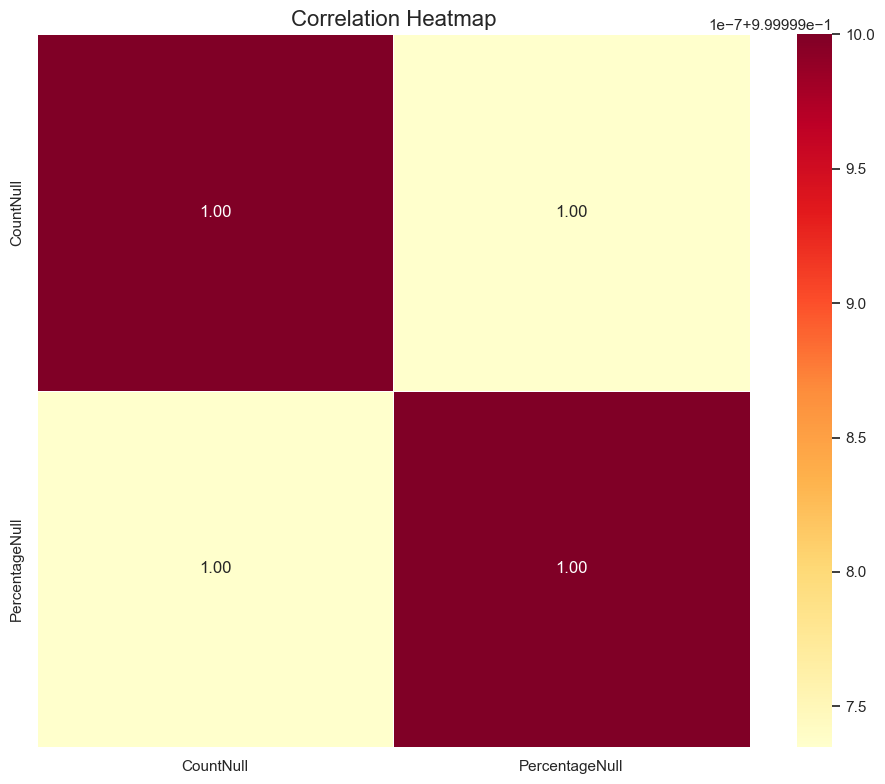

In [ ]:
from db_utils import Plotter

Plotter(df).correlation_map()

In [ ]:
import plotly.express as px

fig = px.histogram(df, "browser", 
                   facet_col="region", 
                   color="region",
                   title="Counts of browser per region",
                   labels={"browser": "browser"},
                   height=1000, 
                   facet_col_wrap=2, 
                   facet_col_spacing=0.1,
                   histnorm='probability'
                   )
fig.update_layout(showlegend=False, xaxis={'categoryorder':'total descending'})
fig.update_yaxes(matches=None, showticklabels=True)
# fig.update_xaxes(showticklabels=True)
fig.show()

In [ ]:
import numpy as np

def percentnull(df_column):
    print(f"{np.round(100 * df_column.isna().sum()/len(df_column), 2)}% of values in the <{df_column.name}> column are null.")

percentnull(df["product_related"])

# Chart Boilerplate Collection

#### 1. Transparent Circle Scatter Plot

In [ ]:
# This is copied straight from another db analysis.
# TODO all variables and categories must be replaced with relevant ones.

category_array = ["I have never written code", "< 1 years", "1-2 years", "3-5 years", "5-10 years", "10-20 years", "20+ years"]
# fig = px.scatter(programming_experience_salary_df, "Programming Experience", "Salary", title="Density of Programming Experience vs Salary")
fig = px.scatter(programming_experience_salary_df, "Programming Experience", "Salary", facet_col=df["Q2"],title="Density of Programming Experience vs Salary")
fig.update_traces(marker=dict(
            opacity=0.05,
            size=20,
            line=dict(
                color='MediumPurple',
                width=0.5
            )))
fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray':category_array})
fig.show()